En este notebook se presenta un análisis exploratorio de datos de departamentos en venta en la Ciudad Autónoma de Buenos Aires. 

- **Análisis descriptivo de precios de departamentos**

- **Mapa del precio del metro cuadrado por barrio** 

- **Modelo de predicción**

**Breve resumen de la obtención de datos y limpieza:**

Se obtienen datos de 18.694 departamentos en venta en CABA. 

Contiene:

- precio
- barrio	
- caracteristicas (sección de la publicación con características principales del inmueble)	
- descripcion_1 (título de la publicación)	
- descripcion_2 (descripción en detalle del inmueble)	

Se crean las columnas:

- precio_usd (convirtiendo el precio a dólares)	
- barrio_caba	(extrae el barrio de la columna barrio)
- m2_cub, antig y dorm (se extraen de la columna caracteristicas)

Para ver en detalle ver el notebook de limpieza en repositorio.

# Datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas
import plotly.io as pio
import numpy as np
from scipy.stats import iqr
pio.renderers.default = 'notebook_connected' 


**Datos de departamentos en venta del sitio Argenprop**

In [2]:
df = pd.read_csv("datos_departamentos.csv",sep=';',encoding="utf-8")
df.head()

,precio,barrio,caracteristicas,descripcion_1,descripcion_2,precio_usd,barrio_caba,m2_cub,antig,dorm
0,USD 155.000 + $120.000 expensas,"Departamento en Venta en Colegiales, Capital F...","['45 m² cubie.', '1 dorm.', '15 años']",LOFT en colegiales CON COCHERA,¡Loft de ensueño en la mejor zona de colegiale...,155000,Colegiales,45.00,15,1
1,USD 149.000,"Departamento en Venta en Villa Ortuzar, Capita...","['49,55 m² cubie.', '1 dorm.', '24 años']",VENTA 2 AMBIENTES VILLA ORTUZAR PARRILLA BALCON,Corredor responsable: graciela menazzi cmcpdjl...,149000,Villa Ortuzar,49.55,24,1
2,USD 550.000 + $750.000 expensas,"Departamento en Venta en Barrio Norte, Capital...","['162 m² cubie.', '3 dorm.', '70 años']","DEPARTAMENTO 3 DOR.C/DEP - BARRIO NORTE, CAPIT...","Pisos de calden - vigilancia 24hs. - Baño, toi...",550000,Barrio Norte,162.00,70,3
3,USD 395.000 + $450.000 expensas,"Departamento en Venta en Barrio Norte, Capital...","['164 m² cubie.', '3 dorm.', '40 años']","Departamento 4 AMB, con Cochera Fija y Baulera...","Oportunidad departamento 4 amb, sobre av. Sant...",395000,Barrio Norte,164.00,40,3
4,USD 295.000,"Departamento en Venta en Villa Urquiza, Capita...","['105 m² cubie.', '2 dorm.', '1 año']",Departamento 3 ambientes a estrenar con cochera,Corredor responsable: alan carlos bosque csi 6...,295000,Villa Urquiza,105.00,1,2


# Limpieza - EDA

**18.694 departamentos en venta**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18694 entries, 0 to 18693
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   precio           18694 non-null  object 
 1   barrio           18694 non-null  object 
 2   caracteristicas  18694 non-null  object 
 3   descripcion_1    18694 non-null  object 
 4   descripcion_2    18694 non-null  object 
 5   precio_usd       18694 non-null  int64  
 6   barrio_caba      18694 non-null  object 
 7   m2_cub           18694 non-null  float64
 8   antig            18694 non-null  int64  
 9   dorm             18694 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 1.4+ MB


**No hay duplicados**

In [4]:
df.duplicated().sum()

0

In [5]:
round(df.describe(),)

,precio_usd,m2_cub,antig,dorm
count,18694.0,18694.0,18694.0,18694.0
mean,186110.0,64.0,24.0,2.0
std,210781.0,44.0,25.0,1.0
min,22000.0,16.0,0.0,1.0
25%,89000.0,37.0,0.0,1.0
50%,129900.0,51.0,15.0,1.0
75%,204000.0,76.0,45.0,2.0
max,4600000.0,621.0,141.0,22.0


**Convierto precio_usd y antig a int32 para eficiencia**

In [6]:
df['precio_usd'] = df['precio_usd'].astype('int32')
df['antig'] = df['antig'].astype('int32')

**Creo variable usd_m2 (valor del m2 en USD)**

In [7]:
df['usd_m2'] = df['precio_usd'] / df['m2_cub']

**El 75% de los departamentos valen menos de USD 203.000**

**El 25% de los departamentos son a estrenar (antiguedad 0 años)** 

**Tienen entre 1 y 22 dormitorios. El 75% de los departamentos tienen entre 1 y 2 dormitorios**

**Hay un rango de departamentos entre USD 426 a USD 14.866 el m2**  	

In [8]:
round(df.describe(),)

,precio_usd,m2_cub,antig,dorm,usd_m2
count,18694.0,18694.0,18694.0,18694.0,18694.0
mean,186110.0,64.0,24.0,2.0,2777.0
std,210781.0,44.0,25.0,1.0,1139.0
min,22000.0,16.0,0.0,1.0,426.0
25%,89000.0,37.0,0.0,1.0,2049.0
50%,129900.0,51.0,15.0,1.0,2593.0
75%,204000.0,76.0,45.0,2.0,3267.0
max,4600000.0,621.0,141.0,22.0,14866.0


**Departamentos con más dormitorios**

In [9]:
df.sort_values(by='dorm')[['precio','descripcion_1','dorm']].tail(10)

,precio,descripcion_1,dorm
11384,USD 1.296.000 + $1.185.000 expensas,Venta Departamento 7 Ambientes Piso Alto al Ri...,7
10580,USD 195.000,Venta Local y 4 Unidades de 2 Ambientes en Pb ...,8
8246,USD 420.000 + $564.000 expensas,VENTA DPTO 450 m2- APTO PROF MONSERRAT-Tza propia,8
8330,USD 359.000 + $327.866 expensas,2 Departamentos 4 y 5 ambientes Luminosos Cong...,8
14217,USD 128.000 + $194.000 expensas,VENTA DEPTO apto profesional en Microcentro,8
9891,USD 450.000 + $800.000 expensas,EXCELENTE PISO EN VENTA APTO./PROF. AV. SANTA ...,8
13675,USD 247.000 + $210.000 expensas,Venta departamento multi familiar balvanera,10
13436,USD 670.000,Departamentos para renta en Recoleta,10
8374,USD 1.800.000,ESPECTACULAR PISO 600 mts2,12
8625,USD 850.000,Petit Hotel de Estilo Francés en venta en Reco...,22


**El 99% de los departamentos valen menos de aprox. USD 1M** 


In [10]:
p99 = np.percentile(df['precio_usd'],99)
print(int(p99))

1053359


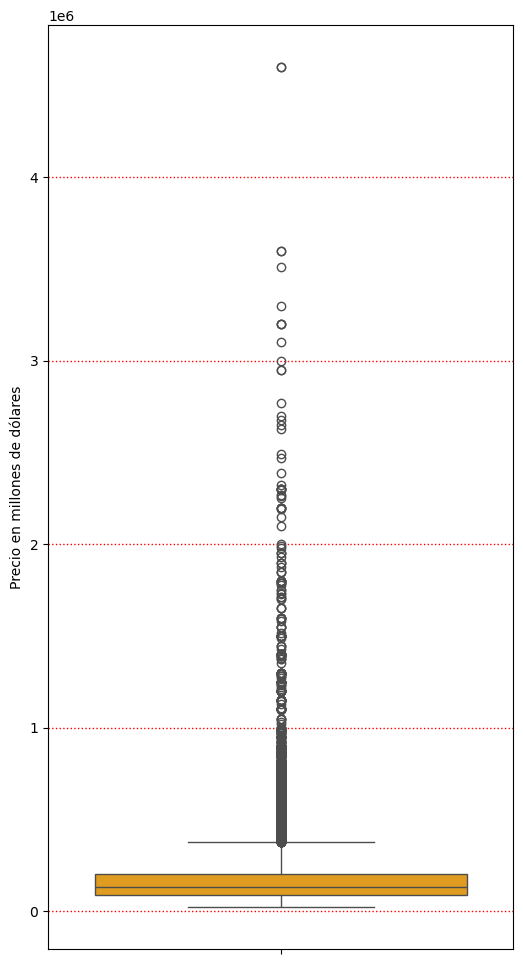

In [11]:
fig, ax = plt.subplots(figsize=(6,12))

sns.boxplot(y="precio_usd",data=df,color='orange')
ax.set_ylabel('Precio en millones de dólares')
plt.grid(axis='y', color='r', linestyle='dotted', linewidth=1) # linea en valores axis y

plt.show()


*   **Hay presencia de Outliers**
-   **Distribucion tiene asimetría positiva (Hay concentración de datos en los valores más bajos, outliers hacen que media>mediana)**

**Outliers**

In [12]:
Q1 = np.percentile(df['precio_usd'],25) # percentil25
Q3 = np.percentile(df['precio_usd'],75) # percentil75
IQR = Q3 - Q1 # rango intercuartil
rango_superior = Q3 + 1.5 * IQR
outliers = df['precio_usd'][df['precio_usd'] >= rango_superior]
cantidad_outliers = len(outliers)

print(f'Rango Superior: {round(rango_superior)}')
print(f'Cantidad de outliers: {cantidad_outliers}')
print(f'Porcentaje de outliers sobre el total: {round(cantidad_outliers/len(df['precio_usd'])*100,2)}%')

Rango Superior: 376500
Cantidad de outliers: 1497
Porcentaje de outliers sobre el total: 8.01%


# Visualizaciones

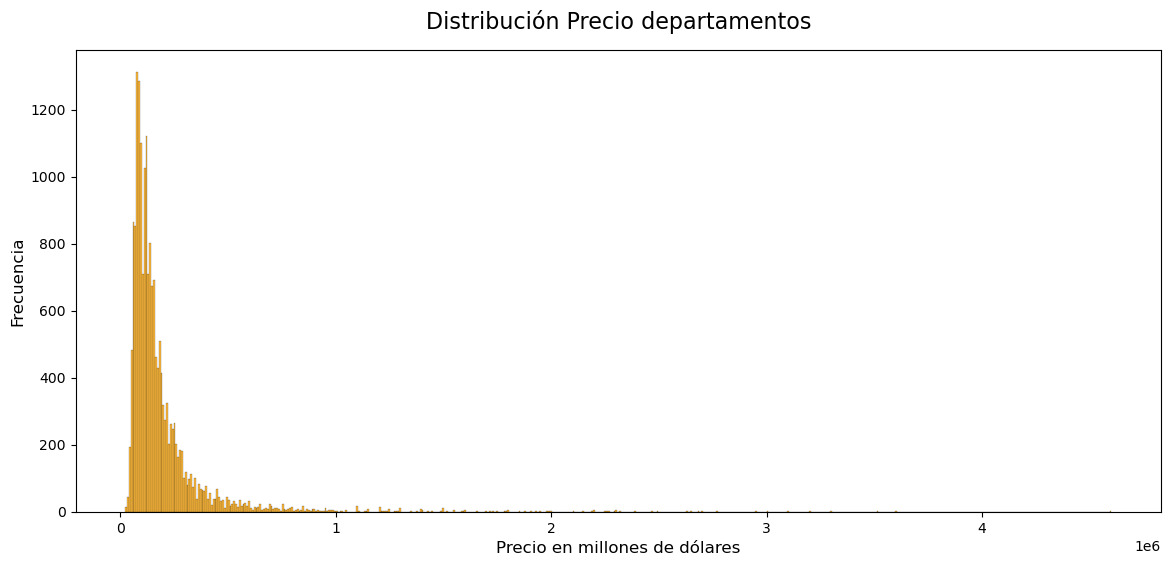

In [13]:
fig, ax = plt.subplots(figsize=(14,6))

ax = sns.histplot(data=df, x='precio_usd',ax=ax,color='orange')
ax.set_title('Distribución Precio departamentos',{'fontsize': 16},pad=15)
ax.set_xlabel('Precio en millones de dólares', size=12)
ax.set_ylabel('Frecuencia', size=12)

plt.show()

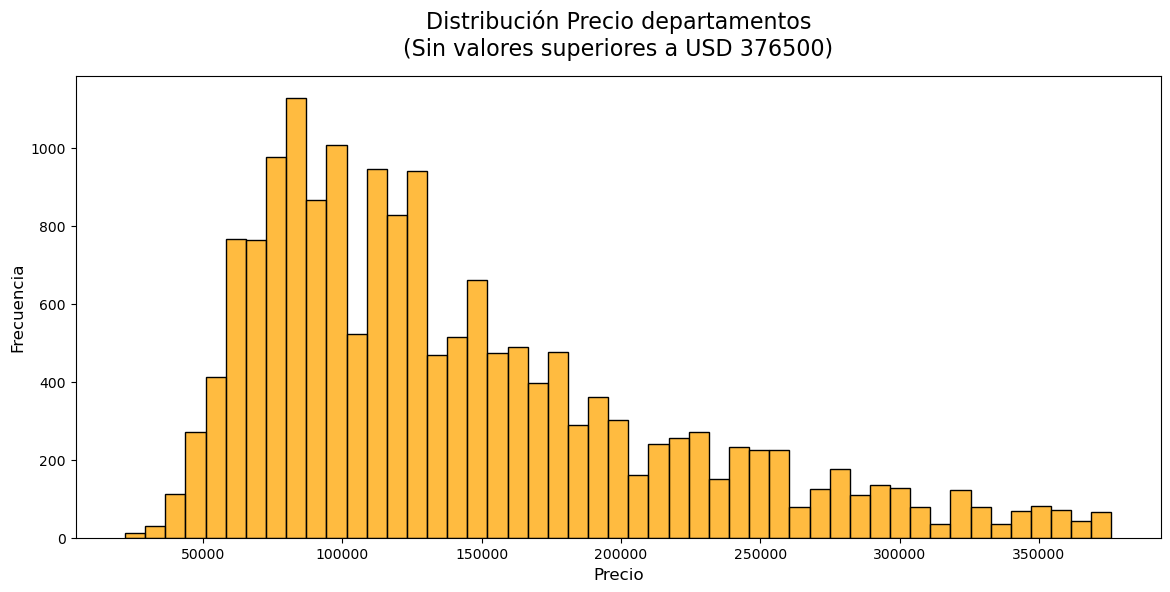

In [14]:
fig, ax = plt.subplots(figsize=(14,6))

datos_sin_outliers = df[df['precio_usd'] <= rango_superior]

ax = sns.histplot(data=datos_sin_outliers, x='precio_usd',ax=ax,color='orange')
ax.set_title(f'Distribución Precio departamentos\n(Sin valores superiores a USD {int(rango_superior)})',{'fontsize': 16},pad=15)
ax.set_xlabel('Precio', size=12)
ax.set_ylabel('Frecuencia', size=12)

plt.show()

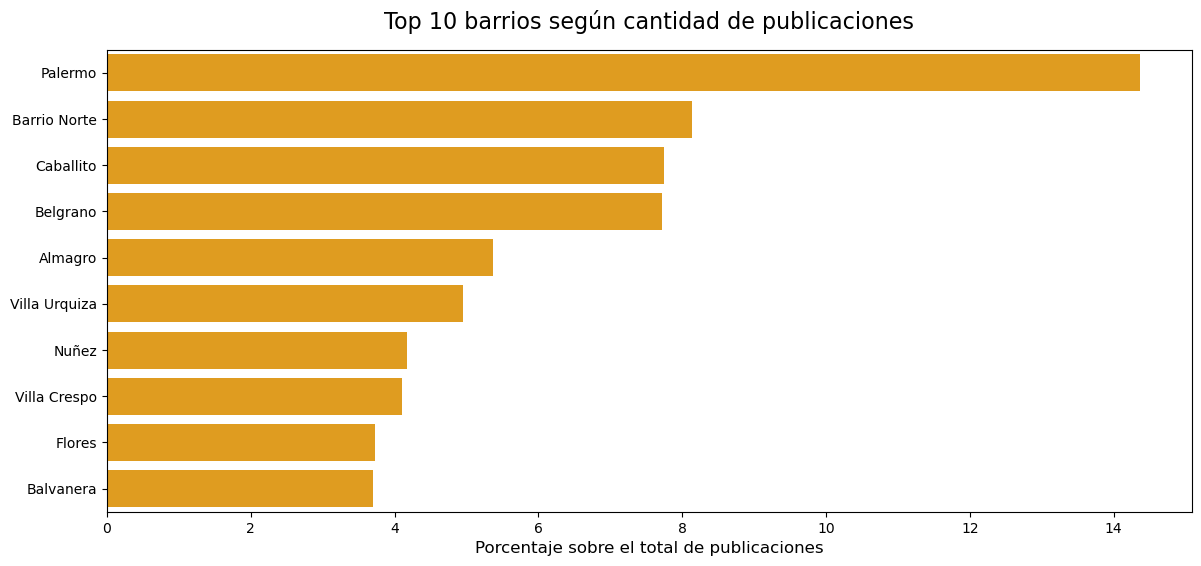

In [15]:
top_10_barrio_porcentaje = df.value_counts('barrio_caba',normalize=True).rename(
    'porcentaje').mul(100).reset_index().sort_values('porcentaje',ascending=False)[0:10]

fig, ax = plt.subplots(figsize=(14,6))

ax = sns.barplot(x="porcentaje", y="barrio_caba", data=top_10_barrio_porcentaje,color='orange')

ax.set_title('Top 10 barrios según cantidad de publicaciones',{'fontsize': 16},pad=15)
ax.set_xlabel('Porcentaje sobre el total de publicaciones', size=12)
ax.set_ylabel('')

plt.show()

# Mapa

**Obtiene los 48 barrios de CABA y sus posiciones geográficas** 

In [16]:
url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson'
geodf = geopandas.read_file(url)
geodf = geodf[['BARRIO','geometry']]
geodf.set_index('BARRIO',inplace=True)
print(len(geodf))
geodf.head()

48


,geometry
BARRIO,
CHACARITA,"MULTIPOLYGON (((-58.45282 -34.59599, -58.45366..."
PATERNAL,"MULTIPOLYGON (((-58.46558 -34.59656, -58.46562..."
VILLA CRESPO,"MULTIPOLYGON (((-58.42375 -34.59783, -58.42495..."
VILLA DEL PARQUE,"MULTIPOLYGON (((-58.49461 -34.61487, -58.49479..."
ALMAGRO,"MULTIPOLYGON (((-58.41287 -34.61412, -58.41282..."


In [17]:
geodf.index.sort_values()

Index(['AGRONOMIA', 'ALMAGRO', 'BALVANERA', 'BARRACAS', 'BELGRANO', 'BOCA',
       'BOEDO', 'CABALLITO', 'CHACARITA', 'COGHLAN', 'COLEGIALES',
       'CONSTITUCION', 'FLORES', 'FLORESTA', 'LINIERS', 'MATADEROS',
       'MONSERRAT', 'MONTE CASTRO', 'NUEVA POMPEYA', 'NUÑEZ', 'PALERMO',
       'PARQUE AVELLANEDA', 'PARQUE CHACABUCO', 'PARQUE CHAS',
       'PARQUE PATRICIOS', 'PATERNAL', 'PUERTO MADERO', 'RECOLETA', 'RETIRO',
       'SAAVEDRA', 'SAN CRISTOBAL', 'SAN NICOLAS', 'SAN TELMO',
       'VELEZ SARSFIELD', 'VERSALLES', 'VILLA CRESPO', 'VILLA DEL PARQUE',
       'VILLA DEVOTO', 'VILLA GRAL. MITRE', 'VILLA LUGANO', 'VILLA LURO',
       'VILLA ORTUZAR', 'VILLA PUEYRREDON', 'VILLA REAL', 'VILLA RIACHUELO',
       'VILLA SANTA RITA', 'VILLA SOLDATI', 'VILLA URQUIZA'],
      dtype='object', name='BARRIO')

**Modifico barrio en df para que esté en mayúsculas**

In [18]:
df['barrio_caba'] = df['barrio_caba'].str.upper()

In [19]:
print(len(df['barrio_caba'].unique()))

55


**Valores que estan en geodf pero no en df**

In [20]:
geodf.index[geodf.index.isin(df['barrio_caba']) == False].unique() 

Index(['VILLA GRAL. MITRE', 'NUEVA POMPEYA', 'SAN NICOLAS', 'RECOLETA'], dtype='object', name='BARRIO')

**Valores que estan en df pero no en geodf**

In [21]:
df.barrio_caba[df.barrio_caba.isin(geodf.index) == False].unique()

array(['BARRIO NORTE', 'CONGRESO', 'VILLA GENERAL MITRE', 'MICROCENTRO',
       'SAN NICOLÁS', 'ONCE', 'PARQUE CENTENARIO', 'ABASTO', 'CENTRO',
       'POMPEYA', 'TRIBUNALES'], dtype=object)

**se corrigen nombres de barrios en df**





In [22]:
reemplazos = {
    'VILLA GENERAL MITRE': 'VILLA GRAL. MITRE',
    'POMPEYA': 'NUEVA POMPEYA',
    'PARQUE CENTENARIO': 'CABALLITO',
    'CONGRESO': 'BALVANERA',
    'ONCE':'BALVANERA',
    'BARRIO NORTE': 'RECOLETA',
    'TRIBUNALES':'SAN NICOLAS',
    'SAN NICOLÁS':'SAN NICOLAS',
    'ABASTO':'BALVANERA',
    'MICROCENTRO':'SAN NICOLAS',
    'CENTRO':'SAN NICOLAS'
}

df['barrio_caba'].replace(reemplazos, inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21784\28036343.py:15: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





**Valores que estan en geodf pero no en df**

In [23]:
geodf.index[geodf.index.isin(df['barrio_caba']) == False].unique() 

Index([], dtype='object', name='BARRIO')

**Valores que estan en df pero no en geodf**

In [24]:
df.barrio_caba[df.barrio_caba.isin(geodf.index) == False].unique()

array([], dtype=object)

**Tabla con valores promedio por barrio**


In [25]:
tabla_valores_promedio = df.groupby('barrio_caba')[['precio_usd','usd_m2','m2_cub']].mean()
tabla_valores_promedio.head()

,precio_usd,usd_m2,m2_cub
barrio_caba,,,
AGRONOMIA,97004.000000,2435.372034,39.750000
ALMAGRO,129056.045771,2460.428933,54.388796
BALVANERA,100355.162105,1885.698399,57.999632
BARRACAS,135932.550847,2182.288514,63.035593
BELGRANO,268748.247922,3360.756071,76.763560


**union de geopandas Dataframe y tabla valores promedio**


In [26]:
merged_df = geodf.merge(tabla_valores_promedio,how='left',left_index=True,right_index=True) 
merged_df.head()

,geometry,precio_usd,usd_m2,m2_cub
BARRIO,,,,
CHACARITA,"MULTIPOLYGON (((-58.45282 -34.59599, -58.45366...",138910.362963,2609.098985,53.442741
PATERNAL,"MULTIPOLYGON (((-58.46558 -34.59656, -58.46562...",112058.716216,2211.805121,53.922973
VILLA CRESPO,"MULTIPOLYGON (((-58.42375 -34.59783, -58.42495...",132969.894256,2507.988645,54.704491
VILLA DEL PARQUE,"MULTIPOLYGON (((-58.49461 -34.61487, -58.49479...",141976.317073,2439.107893,58.164499
ALMAGRO,"MULTIPOLYGON (((-58.41287 -34.61412, -58.41282...",129056.045771,2460.428933,54.388796


In [27]:
merged_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 48 entries, CHACARITA to BOCA
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    48 non-null     geometry
 1   precio_usd  48 non-null     float64 
 2   usd_m2      48 non-null     float64 
 3   m2_cub      48 non-null     float64 
dtypes: float64(3), geometry(1)
memory usage: 2.9+ KB


**Convierto valores a entero**

In [28]:
merged_df['precio_usd'] = merged_df['precio_usd'].astype(int)
merged_df['usd_m2'] = merged_df['usd_m2'].astype(int)
merged_df['m2_cub'] = merged_df['m2_cub'].astype(int)
merged_df.head()

,geometry,precio_usd,usd_m2,m2_cub
BARRIO,,,,
CHACARITA,"MULTIPOLYGON (((-58.45282 -34.59599, -58.45366...",138910,2609,53
PATERNAL,"MULTIPOLYGON (((-58.46558 -34.59656, -58.46562...",112058,2211,53
VILLA CRESPO,"MULTIPOLYGON (((-58.42375 -34.59783, -58.42495...",132969,2507,54
VILLA DEL PARQUE,"MULTIPOLYGON (((-58.49461 -34.61487, -58.49479...",141976,2439,58
ALMAGRO,"MULTIPOLYGON (((-58.41287 -34.61412, -58.41282...",129056,2460,54


**Mapa**

In [29]:
fig = px.choropleth(merged_df,
                   geojson=merged_df.geometry,
                   locations=merged_df.index,
                   color="usd_m2",color_continuous_scale="Viridis",
                   projection="mercator",
                   labels={'BARRIO': 'Barrio','usd_m2':'Precio m2 en USD'})

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

fig.update_layout(title_text='Precio promedio del metro cuadrado de departamentos por barrio <br>CABA (Mayo 2025)')

fig.update_layout(coloraxis_colorbar_x=0.8,coloraxis_colorbar_y=0.5)

fig.show()

# Modelo Predictivo

**Predecir el precio de un departamento en USD con características como barrio, m2, dormitorios, antiguedad y descripción de la propiedad**

**Modelos: Decision Tree - Random Forest - Lightgbm - Catboost**

**Se transforma la columna Barrio que es categórica en numérica con Target Encoder y columna Descripcion que es texto en numérica con TF-IDF**

In [32]:
df.head()

,precio,barrio,caracteristicas,descripcion_1,descripcion_2,precio_usd,barrio_caba,m2_cub,antig,dorm,usd_m2
0,USD 155.000 + $120.000 expensas,"Departamento en Venta en Colegiales, Capital F...","['45 m² cubie.', '1 dorm.', '15 años']",LOFT en colegiales CON COCHERA,¡Loft de ensueño en la mejor zona de colegiale...,155000,COLEGIALES,45.00,15,1,3444.444444
1,USD 149.000,"Departamento en Venta en Villa Ortuzar, Capita...","['49,55 m² cubie.', '1 dorm.', '24 años']",VENTA 2 AMBIENTES VILLA ORTUZAR PARRILLA BALCON,Corredor responsable: graciela menazzi cmcpdjl...,149000,VILLA ORTUZAR,49.55,24,1,3007.063572
2,USD 550.000 + $750.000 expensas,"Departamento en Venta en Barrio Norte, Capital...","['162 m² cubie.', '3 dorm.', '70 años']","DEPARTAMENTO 3 DOR.C/DEP - BARRIO NORTE, CAPIT...","Pisos de calden - vigilancia 24hs. - Baño, toi...",550000,RECOLETA,162.00,70,3,3395.061728
3,USD 395.000 + $450.000 expensas,"Departamento en Venta en Barrio Norte, Capital...","['164 m² cubie.', '3 dorm.', '40 años']","Departamento 4 AMB, con Cochera Fija y Baulera...","Oportunidad departamento 4 amb, sobre av. Sant...",395000,RECOLETA,164.00,40,3,2408.536585
4,USD 295.000,"Departamento en Venta en Villa Urquiza, Capita...","['105 m² cubie.', '2 dorm.', '1 año']",Departamento 3 ambientes a estrenar con cochera,Corredor responsable: alan carlos bosque csi 6...,295000,VILLA URQUIZA,105.00,1,2,2809.523810


**se elimina columnas que no interesan**


In [33]:
df.drop(columns=['precio','barrio','caracteristicas','usd_m2'],inplace=True)
df.head()

,descripcion_1,descripcion_2,precio_usd,barrio_caba,m2_cub,antig,dorm
0,LOFT en colegiales CON COCHERA,¡Loft de ensueño en la mejor zona de colegiale...,155000,COLEGIALES,45.00,15,1
1,VENTA 2 AMBIENTES VILLA ORTUZAR PARRILLA BALCON,Corredor responsable: graciela menazzi cmcpdjl...,149000,VILLA ORTUZAR,49.55,24,1
2,"DEPARTAMENTO 3 DOR.C/DEP - BARRIO NORTE, CAPIT...","Pisos de calden - vigilancia 24hs. - Baño, toi...",550000,RECOLETA,162.00,70,3
3,"Departamento 4 AMB, con Cochera Fija y Baulera...","Oportunidad departamento 4 amb, sobre av. Sant...",395000,RECOLETA,164.00,40,3
4,Departamento 3 ambientes a estrenar con cochera,Corredor responsable: alan carlos bosque csi 6...,295000,VILLA URQUIZA,105.00,1,2


**Distribuciones de variables**

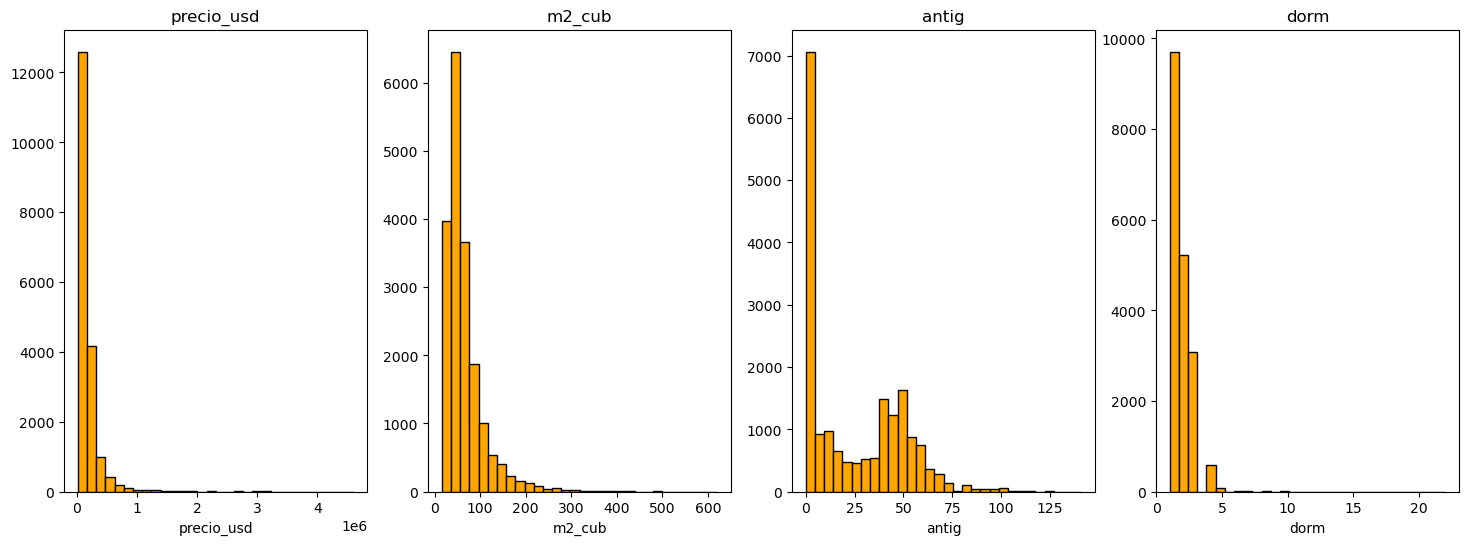

In [34]:
features = ['precio_usd', 'm2_cub', 'antig','dorm']
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

for i, feature in enumerate(features):
    axes[i].hist(df[feature], bins=30, color='orange', edgecolor='black')
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel(feature)
    
plt.show()

**Correlación entre variables**

In [35]:
round(df[features].corr(method='spearman'),2)


,precio_usd,m2_cub,antig,dorm
precio_usd,1.00,0.79,-0.13,0.61
m2_cub,0.79,1.00,0.19,0.84
antig,-0.13,0.19,1.00,0.29
dorm,0.61,0.84,0.29,1.00


## Convertir Barrio a valor númerico

In [36]:
df['barrio_caba'].unique()

array(['COLEGIALES', 'VILLA ORTUZAR', 'RECOLETA', 'VILLA URQUIZA',
       'RETIRO', 'BALVANERA', 'FLORES', 'PALERMO', 'FLORESTA', 'BELGRANO',
       'CABALLITO', 'NUÑEZ', 'VILLA CRESPO', 'SAN CRISTOBAL',
       'VILLA DEVOTO', 'SAAVEDRA', 'MONSERRAT', 'CHACARITA', 'BOEDO',
       'BOCA', 'ALMAGRO', 'SAN TELMO', 'COGHLAN', 'VILLA GRAL. MITRE',
       'SAN NICOLAS', 'PARQUE CHACABUCO', 'VILLA PUEYRREDON',
       'VILLA DEL PARQUE', 'BARRACAS', 'VILLA LUGANO', 'VILLA SANTA RITA',
       'PARQUE AVELLANEDA', 'VILLA LURO', 'CONSTITUCION',
       'PARQUE PATRICIOS', 'MATADEROS', 'AGRONOMIA', 'PUERTO MADERO',
       'MONTE CASTRO', 'VILLA REAL', 'LINIERS', 'PATERNAL', 'PARQUE CHAS',
       'NUEVA POMPEYA', 'VERSALLES', 'VELEZ SARSFIELD', 'VILLA RIACHUELO',
       'VILLA SOLDATI'], dtype=object)

**Variable barrio no tiene un orden: No puede hacerse Ordinal Encoding.** 

**Se puede hacer One-Hot Encoding pero crearia n-1 columnas. Agregaria mas dimensionalidad.** 

**Se usa Target Encoding (también llamado Mean Encoding). Consiste en reemplazar cada categoría de una variable por el promedio de la variable objetivo para esa categoría.**

**Para hacer esto se agregara la transformacion en el pipeline del modelo predictivo más adelante**

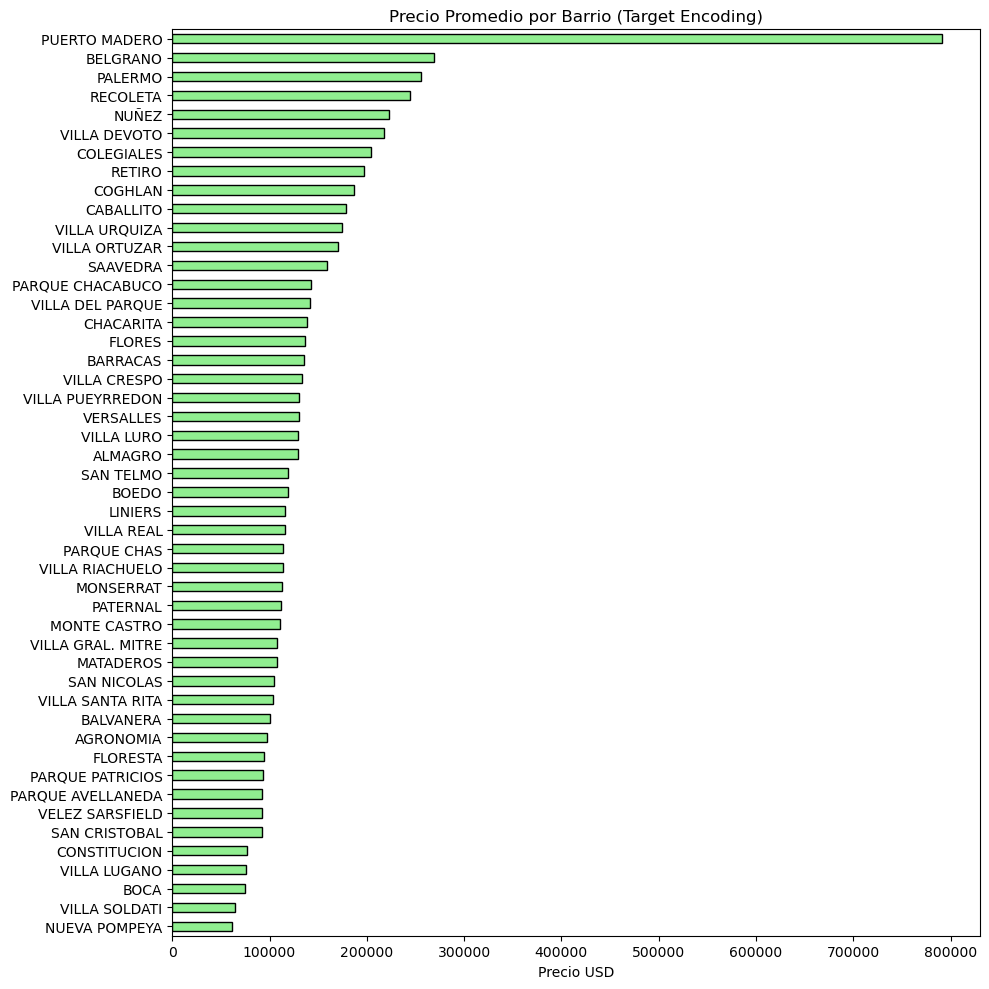

In [37]:
# Calcular precios medios por barrio 
precio_por_barrio = df.groupby('barrio_caba')['precio_usd'].mean().sort_values()
# Graficar
plt.figure(figsize=(10, 10))
precio_por_barrio.plot.barh(color='lightgreen', edgecolor='black')
plt.title('Precio Promedio por Barrio (Target Encoding)')
plt.xlabel('Precio USD')
plt.ylabel('')
plt.tight_layout()
plt.show()

## Convertir descripción (TF-IDF)

**(Term Frequency-Inverse Document Frequency)**

**El TF-IDF es una técnica para vectorizar texto. Considera no solo la frecuencia de las palabras, sino también su importancia relativa en el conjunto de documentos.**

**Se unen las descripciones:**

In [38]:
df[['descripcion_1','descripcion_2']].head(5)

,descripcion_1,descripcion_2
0,LOFT en colegiales CON COCHERA,¡Loft de ensueño en la mejor zona de colegiale...
1,VENTA 2 AMBIENTES VILLA ORTUZAR PARRILLA BALCON,Corredor responsable: graciela menazzi cmcpdjl...
2,"DEPARTAMENTO 3 DOR.C/DEP - BARRIO NORTE, CAPIT...","Pisos de calden - vigilancia 24hs. - Baño, toi..."
3,"Departamento 4 AMB, con Cochera Fija y Baulera...","Oportunidad departamento 4 amb, sobre av. Sant..."
4,Departamento 3 ambientes a estrenar con cochera,Corredor responsable: alan carlos bosque csi 6...


In [39]:
df['descripcion_total'] = df['descripcion_1'] + ' ' + df['descripcion_2']

In [40]:
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import unicodedata

nltk.download('stopwords')
# Eliminación de stopwords
stop_words = stopwords.words('spanish')
custom_stopwords = stop_words + ['corredor', 'responsable', 'cpi', 'contacto', 'cmcpsi','m2','x','mas',
                                 'venta','venta departamento','cucicba','departamento']

def remove_accents(text): # eliminar tildes
    return ''.join(
        c for c in unicodedata.normalize('NFKD', text)
        if not unicodedata.combining(c))

def preprocess(text):
    text = remove_accents(text) # eliminar tildes
    text = re.sub(r'[^\w\s]', '', text.lower())  # eliminar puntuación y pasar a minúsculas
    return ' '.join([word for word in text.split() if word not in custom_stopwords])

df['descripcion_clean'] = df['descripcion_total'].apply(preprocess)

# Configurar TF-IDF
tfidf = TfidfVectorizer(
    max_features=100, # Top palabras
    token_pattern=r'(?u)\b[a-zA-Z][a-zA-Z0-9]*\b', # Excluye texto solo con numeros
    ngram_range=(1, 2), # Unigramas y bigramas
    stop_words=custom_stopwords)

# Aplicar a las descripciones
X_text = tfidf.fit_transform(df['descripcion_clean'])
tfidf_df = pd.DataFrame(X_text.toarray(), columns=tfidf.get_feature_names_out())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
tfidf_df.head(5)

,abierta,aire,aires,alto,amb,ambiente,ambientes,ambientes balcon,amenities,amplio,...,terraza,toilette,tres,ubicacion,ubicado,unidad,unidades,villa,vista,zona
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.739355
1,0.0,0.0,0.0,0.0,0.129365,0.0,0.216065,0.0,0.164217,0.000000,...,0.163105,0.000000,0.000000,0.0,0.000000,0.0,0.174973,0.296699,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.283650,0.000000
3,0.0,0.0,0.0,0.0,0.273886,0.0,0.000000,0.0,0.000000,0.126841,...,0.000000,0.000000,0.199834,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.115861,0.0,0.000000,0.000000,...,0.000000,0.264258,0.000000,0.0,0.175541,0.0,0.000000,0.238649,0.235959,0.000000


In [42]:
print(tfidf.get_feature_names_out()[:100]) 

['abierta' 'aire' 'aires' 'alto' 'amb' 'ambiente' 'ambientes'
 'ambientes balcon' 'amenities' 'amplio' 'apto' 'apto credito' 'av'
 'avenida' 'bajo' 'bajo mesada' 'balcon' 'balcon corrido' 'bano'
 'bano completo' 'barrio' 'baulera' 'belgrano' 'buenos' 'buenos aires'
 'caballito' 'calle' 'caracteristicas' 'categoria' 'ciudad' 'cochera'
 'cocina' 'cocina integrada' 'comedor' 'completo' 'contrafrente' 'corazon'
 'corrido' 'credito' 'cuadras' 'cuenta' 'dependencia' 'depto' 'dormitorio'
 'dormitorios' 'dos' 'edificio' 'encuentra' 'entrega' 'espacio' 'estrenar'
 'excelente' 'excelente ubicacion' 'frente' 'gran' 'hermoso' 'ideal'
 'independiente' 'integrada' 'lavadero' 'living' 'living comedor'
 'luminoso' 'luz' 'mesada' 'metros' 'monoambiente' 'muebles' 'nuevo'
 'oportunidad' 'orientacion' 'palermo' 'parque' 'parrilla' 'patio' 'piso'
 'pisos' 'placard' 'planta' 'posee' 'principal' 'profesional' 'propiedad'
 'recoleta' 'salida' 'salida balcon' 'san' 'semipiso' 'subte' 'suite'
 'terraza' 'toile

# Prueba de modelos

**variable target: precio_usd**

**features: barrio, m2, dormitorios, antiguedad, descripcion**

In [55]:
df[['precio_usd','barrio_caba','m2_cub','antig','dorm','descripcion_total']].head()

,precio_usd,barrio_caba,m2_cub,antig,dorm,descripcion_total
0,155000,COLEGIALES,45.00,15,1,LOFT en colegiales CON COCHERA ¡Loft de ensueñ...
1,149000,VILLA ORTUZAR,49.55,24,1,VENTA 2 AMBIENTES VILLA ORTUZAR PARRILLA BALCO...
2,550000,RECOLETA,162.00,70,3,"DEPARTAMENTO 3 DOR.C/DEP - BARRIO NORTE, CAPIT..."
3,395000,RECOLETA,164.00,40,3,"Departamento 4 AMB, con Cochera Fija y Baulera..."
4,295000,VILLA URQUIZA,105.00,1,2,Departamento 3 ambientes a estrenar con cocher...


**Transformaciones:** 

- **Se transforma la variable barrio a numerica con Target Encoding: Reemplaza cada barrio por el precio promedio de las propiedades en ese barrio.** 

- **Se separa el dataset en train y test antes de hacer transformaciones para no generar data leakage. De esta forma el modelo no ve la distribución del test durante el entrenamiento.**




In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time

## Modelos base sin usar TF-IDF

**Decision Tree, Random Forest y LightGBM sin utilizar descripción**

In [56]:
X = df[['barrio_caba','m2_cub','antig','dorm']]
y = df['precio_usd']

# define qué columnas son numéricas 
numeric_features = ['m2_cub','antig','dorm']

# preprocesador con transformaciones específicas
preprocessor = ColumnTransformer(
    transformers=[
        ('barrio', TargetEncoder(smoothing=10), ['barrio_caba']), # Target Encoding para barrio. smoothing=10 suaviza valores para evitar overfitting en barrios con pocos ejemplos.
        ('num', 'passthrough', numeric_features)])

**Decision Tree (baseline)**

In [ ]:
# pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('model', DecisionTreeRegressor(random_state=42))]) # Modelo default

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

t0=time.time()
pipeline.fit(X_train, y_train) # el scaler solo ve X_train
y_pred = pipeline.predict(X_test)  # Scaleará X_test con parámetros de train
time_taken = time.time()-t0

# Cálculo de métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {round(mae,2)}")
print(f"RMSE: {round(rmse,2)}")
print(f"R2: {round(r2,4)}")
print(f"Tiempo total: {time_taken:.2f} segundos")

MAE: 42884.82
RMSE: 117900.91
R2: 0.6583
Tiempo total: 0.12 segundos


**Random Forest**


In [ ]:
# pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('model', RandomForestRegressor(random_state=42))]) # Modelo default

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

t0=time.time()
pipeline.fit(X_train, y_train) # el scaler solo ve X_train
y_pred = pipeline.predict(X_test)  # Scaleará X_test con parámetros de train
time_taken = time.time()-t0

# Cálculo de métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {round(mae,2)}")
print(f"RMSE: {round(rmse,2)}")
print(f"R2: {round(r2,4)}")
print(f"Tiempo total: {time_taken:.2f} segundos")

MAE: 34946.82
RMSE: 79679.35
R2: 0.8439
Tiempo total: 3.57 segundos


**LGBM**

In [ ]:
# pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('model', LGBMRegressor(random_state=42))]) # Modelo default

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

t0=time.time()
pipeline.fit(X_train, y_train) # el scaler solo ve X_train
y_pred = pipeline.predict(X_test)  # Scaleará X_test con parámetros de train
time_taken = time.time()-t0

# Cálculo de métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {round(mae,2)}")
print(f"RMSE: {round(rmse,2)}")
print(f"R2: {round(r2,4)}")
print(f"Tiempo total: {time_taken:.2f} segundos")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 14955, number of used features: 4
[LightGBM] [Info] Start training from score 186576.470077
MAE: 33982.98
RMSE: 74384.51
R2: 0.864
Tiempo total: 0.57 segundos


c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



## Modelos base con TF-IDF

**Decision Tree, Random Forest y LightGBM utilizando descripción con transformacion TF-IDF**

In [60]:
# se une el dataset de TF-IDF con las variables de df
X = pd.concat([tfidf_df,df[['barrio_caba','m2_cub','antig','dorm']]], axis=1) 
y = df['precio_usd']

# define qué columnas son numéricas y cuáles son TF-IDF
numeric_features = ['m2_cub','antig','dorm']
text_features = tfidf_df.columns  # Columnas de TF-IDF

# preprocesador con transformaciones específicas
preprocessor = ColumnTransformer(
    transformers=[
        ('barrio', TargetEncoder(smoothing=10), ['barrio_caba']), # Target Encoding para barrio. smoothing=10 suaviza valores para evitar overfitting en barrios con pocos ejemplos.
        ('text', 'passthrough', text_features), # TF-IDF sin escalar
        ('num', 'passthrough', numeric_features)])

**Decision Tree (baseline)**

In [ ]:
# pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('model', DecisionTreeRegressor(random_state=42))]) # Modelo default

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

t0=time.time()
pipeline.fit(X_train, y_train) # el scaler solo ve X_train
y_pred = pipeline.predict(X_test)  # Scaleará X_test con parámetros de train
time_taken = time.time()-t0

# Cálculo de métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {round(mae,2)}")
print(f"RMSE: {round(rmse,2)}")
print(f"R2: {round(r2,4)}")
print(f"Tiempo total: {time_taken:.2f} segundos")

MAE: 43924.41
RMSE: 106200.01
R2: 0.7227
Tiempo total: 1.04 segundos


**Hiperparámetros del modelo default**

In [62]:
pipeline.named_steps['model'].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

**Random Forest**


In [ ]:
# pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('model', RandomForestRegressor(random_state=42))]) # Modelo default

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

t0=time.time()
pipeline.fit(X_train, y_train) # Al hacer pipeline.fit(X_train), el scaler solo ve X_train
y_pred = pipeline.predict(X_test)  # Scaleará X_test con parámetros de train
time_taken = time.time()-t0

# Cálculo de métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {round(mae,2)}")
print(f"RMSE: {round(rmse,2)}")
print(f"R2: {round(r2,4)}")
print(f"Tiempo total: {time_taken:.2f} segundos")

MAE: 31025.23
RMSE: 69496.38
R2: 0.8813
Tiempo total: 55.65 segundos


**Hiperparámetros del modelo default**

In [64]:
pipeline.named_steps['model'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

**LGBM**

In [ ]:
# pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('model', LGBMRegressor(random_state=42))]) # Modelo default

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

t0=time.time()
pipeline.fit(X_train, y_train) # Al hacer pipeline.fit(X_train), el scaler solo ve X_train
y_pred = pipeline.predict(X_test)  # Scaleará X_test con parámetros de train
time_taken = time.time()-t0

# Cálculo de métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {round(mae,2)}")
print(f"RMSE: {round(rmse,2)}")
print(f"R2: {round(r2,4)}")
print(f"Tiempo total: {time_taken:.2f} segundos")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25910
[LightGBM] [Info] Number of data points in the train set: 14955, number of used features: 104
[LightGBM] [Info] Start training from score 186576.470077
MAE: 32101.34
RMSE: 68961.35
R2: 0.8831
Tiempo total: 0.68 segundos


c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



**Hiperparámetros del modelo default**

In [66]:
pipeline.named_steps['model'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

## Catboost

**El modelo Catboost es un algoritmo de boosting que maneja variables categóricas de forma nativa.** 

**Por lo tanto, no es necesario hacer Target Encoding a Barrio. Ni TF-IDF a Descripcion.**

In [ ]:
from catboost import CatBoostRegressor, Pool

X = df[['descripcion_total', 'barrio_caba', 'm2_cub', 'antig', 'dorm']]
y = df['precio_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# Columnas categóricas y de texto
cat_features = ['barrio_caba']
text_features = ['descripcion_total']

# Crear Pool de CatBoost
train_pool = Pool(X_train, label=y_train, cat_features=cat_features, text_features=text_features)
test_pool = Pool(X_test, label=y_test, cat_features=cat_features, text_features=text_features)

# Modelo
model = CatBoostRegressor( # Modelo default
    random_state=42,
    verbose=100,
    eval_metric='R2',
    early_stopping_rounds=30)

t0 = time.time()
# Entrenamiento
model.fit(train_pool, eval_set=test_pool)
# Predicción
y_pred = model.predict(X_test)
time_taken = time.time() - t0

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMAE: {round(mae,2)}")
print(f"RMSE: {round(rmse,2)}")
print(f"R2: {round(r2,4)}")
print(f"Tiempo total: {time_taken:.2f} segundos")

Learning rate set to 0.077864
0:	learn: 0.0936113	test: 0.0875168	best: 0.0875168 (0)	total: 207ms	remaining: 3m 26s
100:	learn: 0.9111185	test: 0.8736627	best: 0.8740186 (99)	total: 15.2s	remaining: 2m 14s
200:	learn: 0.9352224	test: 0.8848142	best: 0.8848142 (200)	total: 29.4s	remaining: 1m 56s
300:	learn: 0.9469499	test: 0.8884407	best: 0.8884407 (300)	total: 43.2s	remaining: 1m 40s
400:	learn: 0.9548357	test: 0.8901894	best: 0.8904110 (390)	total: 57s	remaining: 1m 25s
500:	learn: 0.9602468	test: 0.8912717	best: 0.8914421 (481)	total: 1m 10s	remaining: 1m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8914421005
bestIteration = 481

Shrink model to first 482 iterations.

MAE: 32231.82
RMSE: 66450.5
R2: 0.8914
Tiempo total: 75.20 segundos


**Mejores modelos:**

* **Random Forest con TF-IDF**
* **LightGBM con TF-IDF**
* **CatBoost**

# Optimización

## Features de TF-IDF

**Valor óptimo de Features de TF-IDF**

**Prueba con distintos valores de features de TF-IDF en RandomForest y LGBM**

**Se prueba con: 1000,500,200,100,50,20**
**y luego con 150,125,100,80**

**valor óptimo = 100**

**Random Forest**

In [ ]:
max_features = [150,125,100,80]

for n_feature in max_features:
    # Configurar TF-IDF
    tfidf = TfidfVectorizer(
        max_features=n_feature, # Top palabras
        token_pattern=r'(?u)\b[a-zA-Z][a-zA-Z0-9]*\b', # Excluye texto solo con numeros
        ngram_range=(1, 2), # Unigramas y bigramas
        stop_words=custom_stopwords)

    # Aplicar a las descripciones
    X_text = tfidf.fit_transform(df['descripcion_clean'])
    tfidf_df = pd.DataFrame(X_text.toarray(), columns=tfidf.get_feature_names_out())

    # se une el dataset de TF-IDF con las variables de df
    X = pd.concat([tfidf_df,df[['barrio_caba','m2_cub','antig','dorm']]], axis=1) 
    y = df['precio_usd']

    # define qué columnas son numéricas y cuáles son TF-IDF
    numeric_features = ['m2_cub','antig','dorm']
    text_features = tfidf_df.columns  # Columnas de TF-IDF

    # preprocesador con transformaciones específicas
    preprocessor = ColumnTransformer(
        transformers=[
            ('barrio', TargetEncoder(smoothing=10), ['barrio_caba']), # Target Encoding para barrio. smoothing=10 suaviza valores para evitar overfitting en barrios con pocos ejemplos.
            ('text', 'passthrough', text_features), # TF-IDF sin escalar
            ('num', 'passthrough', numeric_features)])

    # pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  
        ('model', RandomForestRegressor(random_state=42))]) # Modelo

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
    
    t0=time.time()
    pipeline.fit(X_train, y_train) # Al hacer pipeline.fit(X_train), el scaler solo ve X_train
    y_pred = pipeline.predict(X_test)  # Scaleará X_test con parámetros de train
    time_taken = time.time()-t0

    # Cálculo de métricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('-'*100)
    print(f'RandomForestRegressor con TF-IDF Features:{n_feature}')
    print(f"MAE: {round(mae,2)}")
    print(f"RMSE: {round(rmse,2)}")
    print(f"R2: {round(r2,4)}")
    print(f"Tiempo total: {time_taken:.2f} segundos")
    print('-'*100)

----------------------------------------------------------------------------------------------------
RandomForestRegressor con TF-IDF Features:150
MAE: 30878.44
RMSE: 68932.87
R2: 0.8832
Tiempo total: 70.09 segundos
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
RandomForestRegressor con TF-IDF Features:125
MAE: 31030.1
RMSE: 68787.84
R2: 0.8837
Tiempo total: 63.81 segundos
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
RandomForestRegressor con TF-IDF Features:100
MAE: 31025.23
RMSE: 69496.38
R2: 0.8813
Tiempo total: 54.79 segundos
----------------------------------------------------------------------------------------------------
--------------------------------------------------

**LightGBM**

In [ ]:
max_features = [150,125,100,80]

for n_feature in max_features:
    # Configurar TF-IDF
    tfidf = TfidfVectorizer(
        max_features=n_feature, # Top palabras
        token_pattern=r'(?u)\b[a-zA-Z][a-zA-Z0-9]*\b', # Excluye texto solo con numeros
        ngram_range=(1, 2), # Unigramas y bigramas
        stop_words=custom_stopwords)

    # Aplicar a las descripciones
    X_text = tfidf.fit_transform(df['descripcion_clean'])
    tfidf_df = pd.DataFrame(X_text.toarray(), columns=tfidf.get_feature_names_out())

    # se une el dataset de TF-IDF con las variables de df
    X = pd.concat([tfidf_df,df[['barrio_caba','m2_cub','antig','dorm']]], axis=1) 
    y = df['precio_usd']

    # define qué columnas son numéricas y cuáles son TF-IDF
    numeric_features = ['m2_cub','antig','dorm']
    text_features = tfidf_df.columns  # Columnas de TF-IDF

    # preprocesador con transformaciones específicas
    preprocessor = ColumnTransformer(
        transformers=[
            ('barrio', TargetEncoder(smoothing=10), ['barrio_caba']), # Target Encoding para barrio. smoothing=10 suaviza valores para evitar overfitting en barrios con pocos ejemplos.
            ('text', 'passthrough', text_features), # TF-IDF sin escalar
            ('num', 'passthrough', numeric_features)])

    # pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  
        ('model', LGBMRegressor(random_state=42))]) # Modelo

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
    
    t0=time.time()
    pipeline.fit(X_train, y_train) # Al hacer pipeline.fit(X_train), el scaler solo ve X_train
    y_pred = pipeline.predict(X_test)  # Scaleará X_test con parámetros de train
    time_taken = time.time()-t0

    # Cálculo de métricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('-'*100)
    print(f'LGBMRegressor con TF-IDF Features:{n_feature}')
    print(f"MAE: {round(mae,2)}")
    print(f"RMSE: {round(rmse,2)}")
    print(f"R2: {round(r2,4)}")
    print(f"Tiempo total: {time_taken:.2f} segundos")
    print('-'*100)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38259
[LightGBM] [Info] Number of data points in the train set: 14955, number of used features: 154
[LightGBM] [Info] Start training from score 186576.470077


c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



----------------------------------------------------------------------------------------------------
LGBMRegressor con TF-IDF Features:150
MAE: 32460.09
RMSE: 69791.18
R2: 0.8803
Tiempo total: 0.65 segundos
----------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32172
[LightGBM] [Info] Number of data points in the train set: 14955, number of used features: 129
[LightGBM] [Info] Start training from score 186576.470077


c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



----------------------------------------------------------------------------------------------------
LGBMRegressor con TF-IDF Features:125
MAE: 32725.98
RMSE: 71270.64
R2: 0.8751
Tiempo total: 0.53 segundos
----------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25910
[LightGBM] [Info] Number of data points in the train set: 14955, number of used features: 104
[LightGBM] [Info] Start training from score 186576.470077


c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



----------------------------------------------------------------------------------------------------
LGBMRegressor con TF-IDF Features:100
MAE: 32101.34
RMSE: 68961.35
R2: 0.8831
Tiempo total: 0.46 segundos
----------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20810
[LightGBM] [Info] Number of data points in the train set: 14955, number of used features: 84
[LightGBM] [Info] Start training from score 186576.470077
----------------------------------------------------------------------------------------------------
LGBMRegressor con TF-IDF Features:80
MAE: 32297.51
RMSE: 69926.53
R2: 0.8798
Tiempo total: 0.45 segundos
--------------------------------------------------------------------------

c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



## Hyperparameter Tuning

### Random Forest - Hyperparameter Tuning


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# se une el dataset de TF-IDF con las variables de df
X = pd.concat([tfidf_df,df[['barrio_caba','m2_cub','antig','dorm']]], axis=1) 
y = df['precio_usd']

# define qué columnas son numéricas y cuáles son TF-IDF
numeric_features = ['m2_cub','antig','dorm']
text_features = tfidf_df.columns  # Columnas de TF-IDF

# preprocesador con transformaciones específicas
preprocessor = ColumnTransformer(
    transformers=[
        ('barrio', TargetEncoder(smoothing=10), ['barrio_caba']), # Target Encoding para barrio. smoothing=10 suaviza valores para evitar overfitting en barrios con pocos ejemplos.
        ('text', 'passthrough', text_features), # TF-IDF sin escalar
        ('num', 'passthrough', numeric_features)])

# pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('model', RandomForestRegressor(random_state=42))]) # Modelo

# Definición del espacio de hiperparámetros
params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=params,
    n_iter=12, # prueba combinaciones aleatorias
    cv=3, # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1)

# Entrenamiento con búsqueda de hiperparámetros
random_search.fit(X_train, y_train)
# Evaluación
best_model_rf = random_search.best_estimator_
y_pred = best_model_rf.predict(X_test)

# Cálculo de métricas
df_results_rf = pd.DataFrame(random_search.cv_results_)
df_results_rf = df_results_rf.sort_values(by='mean_test_score', ascending=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('-'*100)
print("Mejores hiperparámetros:", random_search.best_params_)
print(f"MAE: {round(mae,2)}")
print(f"RMSE: {round(rmse,2)}")
print(f"R2: {round(r2,4)}")
print(f"Tiempo total búsqueda hiperparámetros: {time_taken:.2f} segundos")
print('-'*100)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------------------------------------------------------------------------------------------------
Mejores hiperparámetros: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': None}
MAE: 30816.6
RMSE: 68735.83
R2: 0.8838
Tiempo total: 54.33 segundos
----------------------------------------------------------------------------------------------------


In [89]:
df_results_rf[['mean_test_score','mean_fit_time','param_model__n_estimators','param_model__max_depth','param_model__min_samples_split','param_model__min_samples_leaf']]

,mean_test_score,mean_fit_time,param_model__n_estimators,param_model__max_depth,param_model__min_samples_split,param_model__min_samples_leaf
7,0.834225,80.725642,200,None,2,1
6,0.834076,40.040383,100,None,2,1
5,0.833257,72.188329,200,None,5,1
3,0.832809,33.148621,100,None,5,2
9,0.832663,65.830500,200,None,5,2
4,0.832554,67.242977,200,None,2,2
0,0.832281,23.264812,100,10,2,1
8,0.831617,20.853720,100,10,5,1
1,0.831001,42.987157,200,10,2,1
10,0.829739,20.822574,100,10,2,2


**Mejor modelo Random Forest** 

In [90]:
t0=time.time()
best_model_rf.fit(X_train, y_train) 
y_pred = best_model_rf.predict(X_test) 
time_taken = time.time()-t0

# Cálculo de métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {round(mae,2)}")
print(f"RMSE: {round(rmse,2)}")
print(f"R2: {round(r2,4)}")
print(f"Tiempo total: {time_taken:.2f} segundos")

MAE: 30816.6
RMSE: 68735.83
R2: 0.8838
Tiempo total: 135.99 segundos


### LightGBM - Hyperparameter Tuning


In [100]:
# se une el dataset de TF-IDF con las variables de df
X = pd.concat([tfidf_df,df[['barrio_caba','m2_cub','antig','dorm']]], axis=1) 
y = df['precio_usd']

# define qué columnas son numéricas y cuáles son TF-IDF
numeric_features = ['m2_cub','antig','dorm']
text_features = tfidf_df.columns  # Columnas de TF-IDF

# preprocesador con transformaciones específicas
preprocessor = ColumnTransformer(
    transformers=[
        ('barrio', TargetEncoder(smoothing=10), ['barrio_caba']), # Target Encoding para barrio. smoothing=10 suaviza valores para evitar overfitting en barrios con pocos ejemplos.
        ('text', 'passthrough', text_features), # TF-IDF sin escalar
        ('num', 'passthrough', numeric_features)])

# pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('model', LGBMRegressor(random_state=42))]) # Modelo

# Definición del espacio de hiperparámetros
params = {
    'model__n_estimators': [100, 200, 300], # default=100
    'model__learning_rate': [0.05, 0.1, 0.2], # default=0.1
    'model__num_leaves': [31, 63], # default=31
    'model__colsample_bytree': [0.8, 1.0]} # default=1.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=params,
    n_iter=30,  
    cv=3,
    scoring='r2', 
    verbose=2,
    random_state=42,
    n_jobs=-1)

# Entrenamiento con búsqueda de hiperparámetros
t0 = time.time()
random_search.fit(X_train, y_train)
time_taken = time.time() - t0

# Evaluación
best_model_lgbm = random_search.best_estimator_
y_pred = best_model_lgbm.predict(X_test)

# Cálculo de métricas
df_results_lightgbm = pd.DataFrame(random_search.cv_results_)
df_results_lightgbm = df_results_lightgbm.sort_values(by='mean_test_score', ascending=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('-'*100)
print("Mejores hiperparámetros:", random_search.best_params_)
print(f"MAE: {round(mae,2)}")
print(f"RMSE: {round(rmse,2)}")
print(f"R2: {round(r2,4)}")
print(f"Tiempo total búsqueda hiperparámetros: {time_taken:.2f} segundos")
print('-'*100)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25910
[LightGBM] [Info] Number of data points in the train set: 14955, number of used features: 104
[LightGBM] [Info] Start training from score 186576.470077
----------------------------------------------------------------------------------------------------
Mejores hiperparámetros: {'model__num_leaves': 31, 'model__n_estimators': 200, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}
MAE: 32125.61
RMSE: 68245.17
R2: 0.8855
Tiempo total búsqueda hiperparámetros: 92.49 segundos
----------------------------------------------------------------------------------------------------


c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



In [101]:
df_results_lightgbm[['mean_test_score','mean_fit_time','param_model__n_estimators',
                     'param_model__learning_rate','param_model__num_leaves',
                     'param_model__colsample_bytree']].head(10)

,mean_test_score,mean_fit_time,param_model__n_estimators,param_model__learning_rate,param_model__num_leaves,param_model__colsample_bytree
21,0.837636,2.724357,200,0.05,31,0.8
6,0.837539,5.041788,200,0.05,63,1.0
13,0.837386,3.573081,300,0.05,31,0.8
20,0.837304,1.338710,100,0.10,31,1.0
23,0.837207,4.870710,200,0.05,63,0.8
25,0.836975,7.363812,300,0.05,63,1.0
28,0.836890,3.867840,300,0.05,31,1.0
8,0.836496,2.376023,200,0.10,31,0.8
17,0.836493,6.316372,300,0.05,63,0.8
2,0.836348,3.723996,200,0.10,31,1.0


**Mejor modelo LightGBM** 

In [102]:
t0=time.time()
best_model_lgbm.fit(X_train, y_train) 
y_pred = best_model_lgbm.predict(X_test)  
time_taken = time.time()-t0

# Cálculo de métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {round(mae,2)}")
print(f"RMSE: {round(rmse,2)}")
print(f"R2: {round(r2,4)}")
print(f"Tiempo total: {time_taken:.2f} segundos")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25910
[LightGBM] [Info] Number of data points in the train set: 14955, number of used features: 104
[LightGBM] [Info] Start training from score 186576.470077
MAE: 32125.61
RMSE: 68245.17
R2: 0.8855
Tiempo total: 1.33 segundos


c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



**Feature Importance del mejor modelo LightGBM**

<Figure size 1200x800 with 0 Axes>

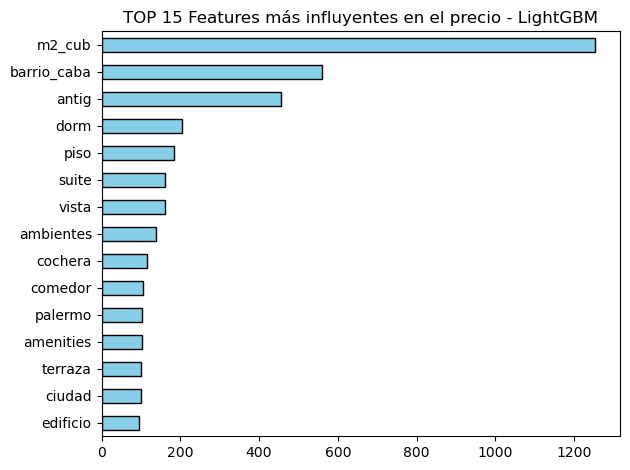

In [121]:
# 1. Obtener modelo y preprocesador entrenado
model = best_model_lgbm.named_steps['model']
preprocessor = best_model_lgbm.named_steps['preprocessor']

# 2. Obtener nombres reales de features post-transformación
feature_names = []

for name, transformer, cols in preprocessor.transformers_:
    if transformer == 'passthrough':
        feature_names.extend(cols)
    elif hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out(cols))
    else:
        # TargetEncoder no tiene get_feature_names_out, pero genera una columna por cada input
        feature_names.extend(cols)

# 3. Obtener relevancia de features
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_})

# 4. Filtrar las top 15
top_features = importance_df.sort_values('importance', ascending=False).head(15)

# 5. Graficar
plt.figure(figsize=(12, 8))
top_features.sort_values('importance').plot.barh(
    x='feature',
    y='importance',
    color='skyblue',
    edgecolor='black',
    legend=False)

plt.title("TOP 15 Features más influyentes en el precio - LightGBM")
plt.ylabel('')
plt.tight_layout()
plt.savefig('importancia_features_lgbm.png',dpi=300)
plt.show()

### Catboost - Hyperparameter Tuning


In [122]:
from itertools import product

X = df[['descripcion_total', 'barrio_caba', 'm2_cub', 'antig', 'dorm']]
y = df['precio_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# Columnas categóricas y de texto
cat_features = ['barrio_caba']
text_features = ['descripcion_total']

mejores_resultados = []

for lr, depth in product([0.05,0.1],[6,8]):
    model = CatBoostRegressor(
        learning_rate=lr,
        depth=depth,
        iterations=600,
        random_state=42,
        verbose=0,
        eval_metric='R2',
        early_stopping_rounds=30)
    
    t0 = time.time()
    model.fit(X_train, y_train, cat_features=cat_features, text_features=text_features)
    y_pred = model.predict(X_test) 
    time_taken = time.time() - t0
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mejores_resultados.append({
    'learning_rate': lr,
    'depth': depth,
    'mae': mae,
    'rmse': rmse,
    'r2': r2,
    'tiempo':time_taken})                              
    
df_results_catboost = pd.DataFrame(mejores_resultados)
df_results_catboost.sort_values(by='r2', ascending=False,inplace=True)
df_results_catboost


,learning_rate,depth,mae,rmse,r2,tiempo
3,0.10,8,30735.357177,64455.004181,0.897864,231.046171
1,0.05,8,31385.158585,65163.533837,0.895606,228.489465
2,0.10,6,31213.625802,65533.814215,0.894417,84.554263
0,0.05,6,32224.069846,66937.917554,0.889844,88.009581


**Cross-validation del mejor modelo para ver estabilidad**

In [123]:
from catboost import cv

X = df[['descripcion_total', 'barrio_caba', 'm2_cub', 'antig', 'dorm']]
y = df['precio_usd']

cat_features = ['barrio_caba']
text_features = ['descripcion_total']
data_pool = Pool(X, label=y, cat_features=cat_features, text_features=text_features)

# Parámetros del modelo
params = {
    'learning_rate': 0.1,
    'depth': 8,
    'loss_function': 'RMSE', 
    'random_seed': 42,
    'verbose': 0,
    'early_stopping_rounds': 30}

# Cross-validation con 3 folds
cv_results = cv(
    pool=data_pool,
    params=params,
    fold_count=3,
    partition_random_seed=42,
    shuffle=True,
    verbose=False,
    early_stopping_rounds=30)

Training on fold [0/3]

bestTest = 73758.75482
bestIteration = 521

Training on fold [1/3]

bestTest = 85054.26214
bestIteration = 525

Training on fold [2/3]

bestTest = 71441.27942
bestIteration = 990



In [124]:
cv_results.iloc[[521,525,990]].sort_values(by='test-RMSE-mean')

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
990,990,76770.021928,7298.434078,27422.498815,4258.822013
525,525,77088.755034,6932.290087,30597.578928,671.399947
521,521,77091.590622,6939.087098,30704.472459,651.568236


# Métricas de mejores modelos

|Modelo       |  MAE  |  RMSE |   R2   | Tiempo (segundos) |
|:-------------:|:-----:|:-----:|:------:|--------|
| Random Forest |   30816   |  68735  |    0.8838   | 136   |
|    LightGBM   | 32125 | 68245 | 0.8855 | 1.33      |
|    Catboost   | 30732 | 64452 | 0.8979 | 224    |


**El mejor modelo Catboost**

- **MAE es 30.732 USD. El precio promedio en la muestra test es 184.242 USD. Entonces el modelo falla en promedio un 16.68%**

- **RMSE es 64.452 USD. métrica que penaliza errores grandes. Sugiere que hay algunas predicciones donde el modelo se equivoca bastante más que el promedio, aunque no lo suficiente como para arruinar el desempeño global (ya que el R² sigue siendo alto). Esto ocurre cuando intenta predecir outliers.**
 
- **R² de 0.8979 significa que explica aprox. el 89% de la variabilidad en los precios de los departamentos.** 

## Mejor Modelo: Catboost

In [127]:
X = df[['descripcion_total', 'barrio_caba', 'm2_cub', 'antig', 'dorm']]
y = df['precio_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# Columnas categóricas y de texto
cat_features = ['barrio_caba']
text_features = ['descripcion_total']

# Crear Pool de CatBoost
train_pool = Pool(X_train, label=y_train, cat_features=cat_features, text_features=text_features)
test_pool = Pool(X_test, label=y_test, cat_features=cat_features, text_features=text_features)

# Modelo
model = CatBoostRegressor( 
    learning_rate=0.1,
    depth=8,
    iterations=600,
    random_state=42,
    verbose=100,
    eval_metric='R2',
    early_stopping_rounds=30)

t0 = time.time()
model.fit(train_pool, eval_set=test_pool)
y_pred = model.predict(X_test)
time_taken = time.time() - t0

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMAE: {round(mae,2)}")
print(f"RMSE: {round(rmse,2)}")
print(f"R2: {round(r2,4)}")
print(f"Tiempo total: {time_taken:.2f} segundos")

0:	learn: 0.1248409	test: 0.1168227	best: 0.1168227 (0)	total: 381ms	remaining: 3m 48s
100:	learn: 0.9321768	test: 0.8840479	best: 0.8840479 (100)	total: 39.6s	remaining: 3m 15s
200:	learn: 0.9555915	test: 0.8919665	best: 0.8919812 (198)	total: 1m 17s	remaining: 2m 33s
300:	learn: 0.9663289	test: 0.8937810	best: 0.8937863 (299)	total: 1m 53s	remaining: 1m 52s
400:	learn: 0.9728384	test: 0.8959405	best: 0.8960150 (393)	total: 2m 28s	remaining: 1m 13s
500:	learn: 0.9770877	test: 0.8971887	best: 0.8971887 (500)	total: 3m 5s	remaining: 36.7s
599:	learn: 0.9802084	test: 0.8978642	best: 0.8978711 (598)	total: 3m 41s	remaining: 0us

bestTest = 0.8978711391
bestIteration = 598

Shrink model to first 599 iterations.

MAE: 30732.69
RMSE: 64452.8
R2: 0.8979
Tiempo total: 224.46 segundos


**Feature Importance del mejor modelo Catboost**

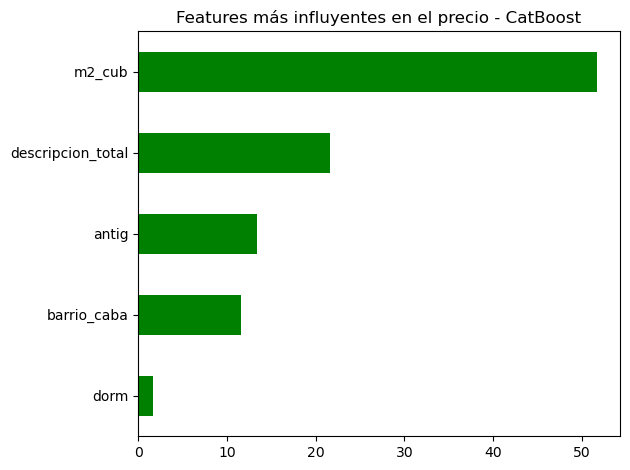

In [ ]:
pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns.values}).sort_values(
    by="Value").plot(x='Feature',kind='barh',color='g',legend=False)
plt.title("Features más influyentes en el precio - CatBoost")
plt.ylabel('')
plt.tight_layout()
plt.savefig('importancia_features_catboost.png',dpi=300)
plt.show()

**Análisis de residuos**

In [128]:
precio_medio_test = y_test.mean()
print(f"MAE: {mae:.2f}")
print(f"Precio promedio (test): {precio_medio_test:.2f}")
print(f"MAE como porcentaje del precio medio: {(mae / precio_medio_test)*100:.2f}%")

MAE: 30732.69
Precio promedio (test): 184242.66
MAE como porcentaje del precio medio: 16.68%


**Entonces el modelo falla en promedio un 16.68%**

- **MAPE Mean Absolute Percentage Error (Error porcentual absoluto medio)**

Es el error absoluto de cada predicción, dividido por el valor real, expresado como porcentaje, y promediado en todos los casos.

$$\mathrm{MAPE}=\frac{1}{n} \sum_{i=1}^n\left|\frac{y_i-\hat{y}_i}{y_i}\right| \times 100$$


In [ ]:
#$$
#\mathrm{MAPE}=\frac{1}{n} \sum_{i=1}^n\left|\frac{y_i-\hat{y}_i}{y_i}\right| \cdot 100
#$$


In [129]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 16.60%


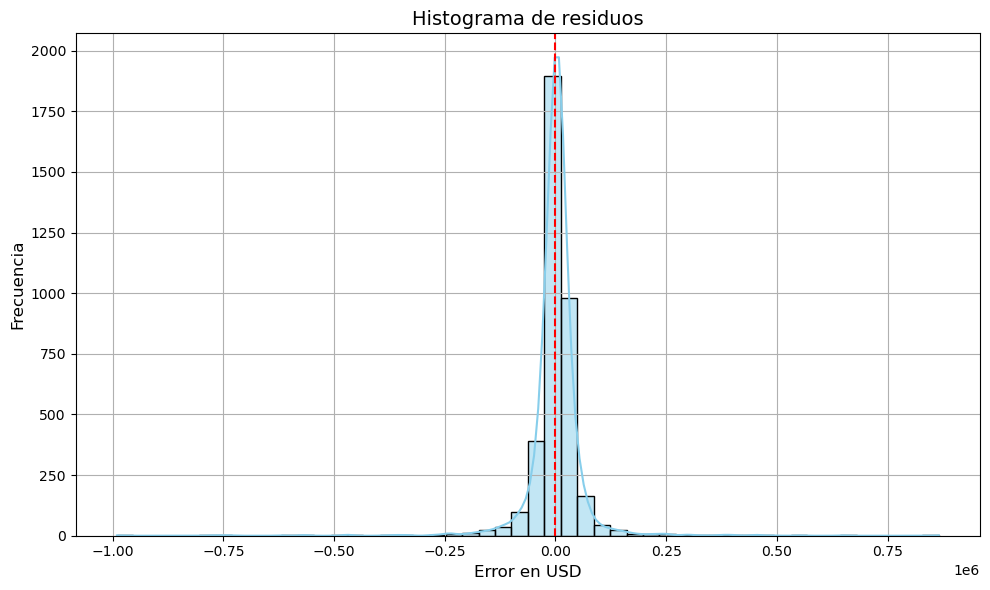

In [132]:
errores = y_pred - y_test # Calcular residuos
plt.figure(figsize=(10, 6))
sns.histplot(errores, bins=50, kde=True, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--') # Línea vertical en 0 para marcar donde no hay error
plt.title("Histograma de residuos", fontsize=14)
plt.xlabel("Error en USD", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


- **El pico principal está muy cerca del cero, indica que el modelo no tiene un sesgo sistemático.**

- **La forma es bastante simétrica y concentrada.**

- **Tiene colas a la izquierda y derecha, aunque mucho más marcadas hacia la izquierda (errores negativos grandes). Esto sugiere que el modelo subestimó fuertemente el precio en los outliers.**



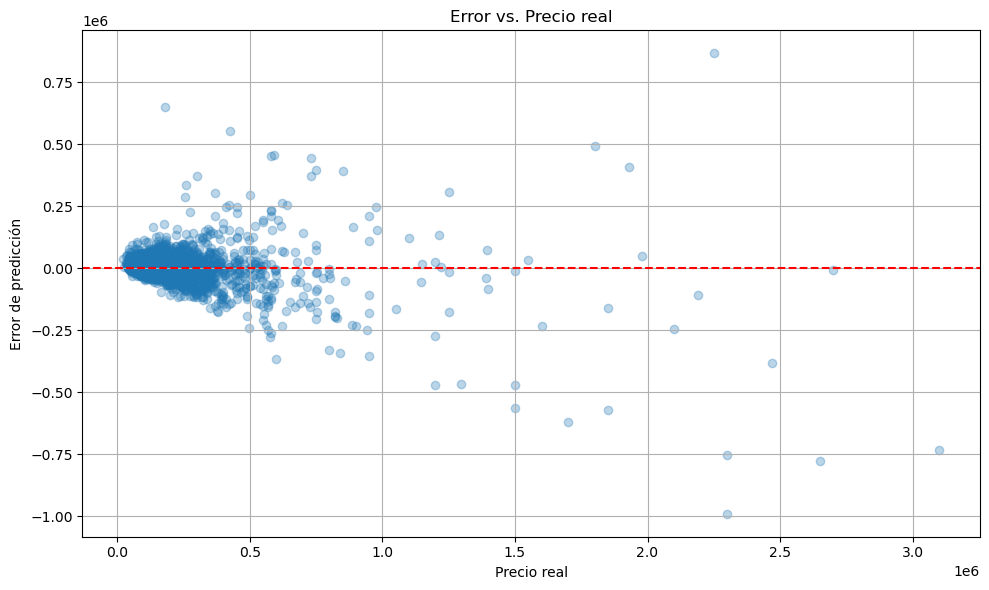

In [133]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, errores, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Precio real')
plt.ylabel('Error de predicción')
plt.title('Error vs. Precio real')
plt.grid(True)
plt.tight_layout()
plt.show()

- **La mayoría de las predicciones se agrupan en precios reales por debajo de USD 500.000, y sus errores son pequeños. Esto indica que el modelo predice con mayor precisión para propiedades más comunes o en el rango medio del mercado.**

- **A medida que aumentan los precios (arriba de USD 500.000), los errores también aumentan en magnitud (tanto positivos como negativos).**

- **Aunque hay outliers, la nube de puntos está bastante simétrica alrededor de la línea roja (error cero), lo cual es un buen signo: el modelo no está sesgado sistemáticamente en sobrestimar o subestimar.**


# Manejo de outliers

**Se podría optar por una opción híbrida separando los datos en dos subconjuntos:**

- **Datos normales: precios dentro del rango típico (hasta 376.500 USD)**

- **Outliers: precios que superan ese límite.**

**Luego, se entrena dos modelos separados: uno para cada conjunto.**

|            Modelo Catboost           |   MAE  |  RMSE  | MAE % del precio medio |   R2   | Tiempo |
|:----------------------:|:------:|:------:|:----------------------:|:------:|:------:|
|         Default        |  32231 | 066450 |            -           | 0.8914 |   75   |
|      Mejor modelo      |  30732 |  64452 |         16.68%         | 0.8979 |   224  |
| Default datos normales |  19841 |  28099 |         14.04%         | 0.8488 |   147  |
| Default outliers | 126806 | 192724 |         18.38%         | 0.8112 |   67   |

In [135]:
Q1 = np.percentile(df['precio_usd'],25) # percentil25
Q3 = np.percentile(df['precio_usd'],75) # percentil75
IQR = Q3 - Q1 # rango intercuartil
rango_superior = Q3 + 1.5 * IQR
outliers = df['precio_usd'][df['precio_usd'] >= rango_superior]
cantidad_outliers = len(outliers)

print(f'Rango Superior: {round(rango_superior)}')
print(f'Cantidad de outliers: {cantidad_outliers}')
print(f'Porcentaje de outliers sobre el total: {round(cantidad_outliers/len(df['precio_usd'])*100,2)}%')

Rango Superior: 376500
Cantidad de outliers: 1497
Porcentaje de outliers sobre el total: 8.01%


**Separar datos normales y outliers**

In [137]:
df_normal = df[df['precio_usd'] <= rango_superior].copy()
df_outliers = df[df['precio_usd'] > rango_superior].copy()
print(f"Datos normales: {df_normal.shape}")
print(f"Outliers: {df_outliers.shape}")

Datos normales: (17197, 9)
Outliers: (1497, 9)


**Entrenar dos modelos: normal y outliers**

**Modelo Normal**

In [ ]:
X = df_normal[['descripcion_total', 'barrio_caba', 'm2_cub', 'antig', 'dorm']]
y = df_normal['precio_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# Columnas categóricas y de texto
cat_features = ['barrio_caba']
text_features = ['descripcion_total']

# Crear Pool de CatBoost
train_pool = Pool(X_train, label=y_train, cat_features=cat_features, text_features=text_features)
test_pool = Pool(X_test, label=y_test, cat_features=cat_features, text_features=text_features)

# Modelo
model = CatBoostRegressor( # modelo default 
    random_state=42,
    verbose=100,
    eval_metric='R2',
    early_stopping_rounds=30)

t0 = time.time()
model.fit(train_pool, eval_set=test_pool)
y_pred = model.predict(X_test)
time_taken = time.time() - t0

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMAE: {round(mae,2)}")
print(f"RMSE: {round(rmse,2)}")
print(f"R2: {round(r2,4)}")
print(f"Tiempo total: {time_taken:.2f} segundos")

Learning rate set to 0.07685
0:	learn: 0.0863134	test: 0.0872404	best: 0.0872404 (0)	total: 127ms	remaining: 2m 7s
100:	learn: 0.8148861	test: 0.8150873	best: 0.8150873 (100)	total: 14.1s	remaining: 2m 5s
200:	learn: 0.8412126	test: 0.8278210	best: 0.8278210 (200)	total: 27.3s	remaining: 1m 48s
300:	learn: 0.8591454	test: 0.8341927	best: 0.8341927 (300)	total: 41.4s	remaining: 1m 36s
400:	learn: 0.8722929	test: 0.8382723	best: 0.8382723 (400)	total: 58.2s	remaining: 1m 26s
500:	learn: 0.8828002	test: 0.8409816	best: 0.8409816 (500)	total: 1m 13s	remaining: 1m 13s
600:	learn: 0.8915924	test: 0.8432664	best: 0.8432891 (595)	total: 1m 27s	remaining: 58s
700:	learn: 0.8996173	test: 0.8450094	best: 0.8450094 (700)	total: 1m 40s	remaining: 43.1s
800:	learn: 0.9064753	test: 0.8462862	best: 0.8463001 (795)	total: 1m 54s	remaining: 28.5s
900:	learn: 0.9127006	test: 0.8478098	best: 0.8478098 (900)	total: 2m 9s	remaining: 14.2s
999:	learn: 0.9180546	test: 0.8488161	best: 0.8488279 (998)	total: 2m

**Análisis de residuos**

In [140]:
precio_medio_test = y_test.mean()
print(f"MAE: {mae:.2f}")
print(f"Precio promedio (test): {precio_medio_test:.2f}")
print(f"MAE como porcentaje del precio medio: {(mae / precio_medio_test)*100:.2f}%")

MAE: 19841.84
Precio promedio (test): 141300.31
MAE como porcentaje del precio medio: 14.04%


**Entonces el modelo con datos típicos falla en promedio un 14.04%**

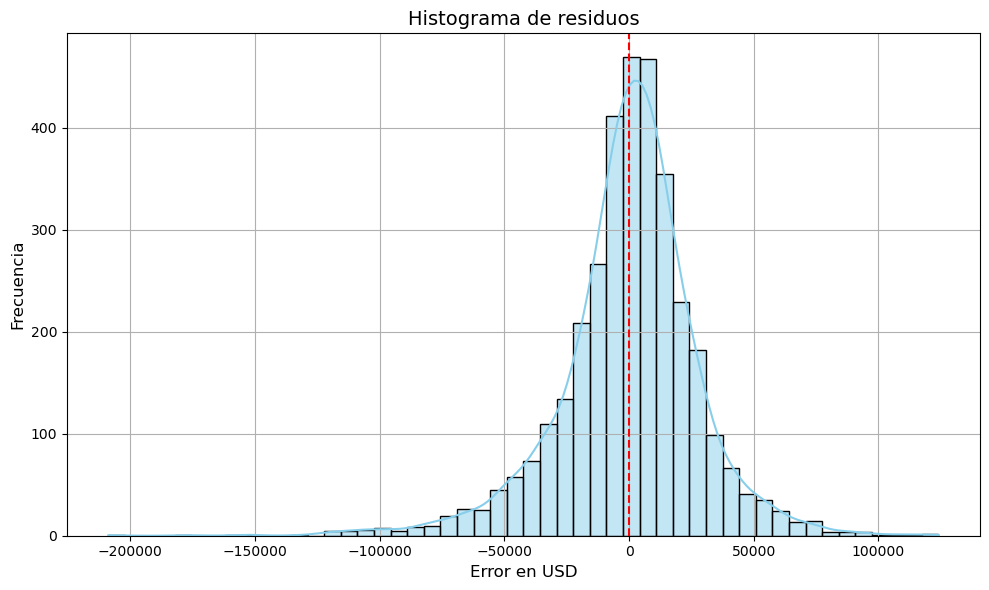

In [141]:
errores = y_pred - y_test # Calcular residuos
plt.figure(figsize=(10, 6))
sns.histplot(errores, bins=50, kde=True, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--') # Línea vertical en 0 para marcar donde no hay error
plt.title("Histograma de residuos", fontsize=14)
plt.xlabel("Error en USD", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

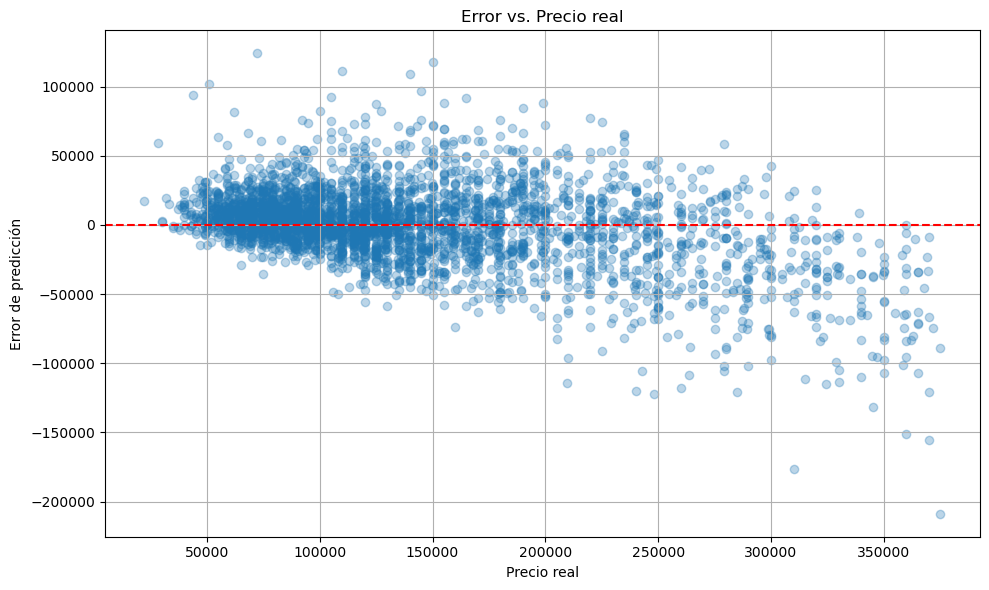

In [142]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, errores, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Precio real')
plt.ylabel('Error de predicción')
plt.title('Error vs. Precio real')
plt.grid(True)
plt.tight_layout()
plt.show()

**Modelo Outliers**

In [144]:
X = df_outliers[['descripcion_total', 'barrio_caba', 'm2_cub', 'antig', 'dorm']]
y = df_outliers['precio_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# Columnas categóricas y de texto
cat_features = ['barrio_caba']
text_features = ['descripcion_total']

# Crear Pool de CatBoost
train_pool = Pool(X_train, label=y_train, cat_features=cat_features, text_features=text_features)
test_pool = Pool(X_test, label=y_test, cat_features=cat_features, text_features=text_features)

# Modelo
model = CatBoostRegressor( # modelo default
    random_state=42,
    verbose=100,
    eval_metric='R2',
    early_stopping_rounds=30)

t0 = time.time()
model.fit(train_pool, eval_set=test_pool)
y_pred = model.predict(X_test)
time_taken = time.time() - t0

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMAE: {round(mae,2)}")
print(f"RMSE: {round(rmse,2)}")
print(f"R2: {round(r2,4)}")
print(f"Tiempo total: {time_taken:.2f} segundos")

Learning rate set to 0.052379
0:	learn: 0.0415120	test: 0.0528126	best: 0.0528126 (0)	total: 108ms	remaining: 1m 47s
100:	learn: 0.7845320	test: 0.7173293	best: 0.7173293 (100)	total: 14.4s	remaining: 2m 8s
200:	learn: 0.8938837	test: 0.7929414	best: 0.7929414 (200)	total: 27.5s	remaining: 1m 49s
300:	learn: 0.9269954	test: 0.8022567	best: 0.8022567 (300)	total: 41.4s	remaining: 1m 36s
400:	learn: 0.9450479	test: 0.8085734	best: 0.8085734 (400)	total: 54.5s	remaining: 1m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8112268941
bestIteration = 450

Shrink model to first 451 iterations.

MAE: 126806.88
RMSE: 192724.3
R2: 0.8112
Tiempo total: 66.84 segundos


**Análisis de residuos**

In [145]:
precio_medio_test = y_test.mean()
print(f"MAE: {mae:.2f}")
print(f"Precio promedio (test): {precio_medio_test:.2f}")
print(f"MAE como porcentaje del precio medio: {(mae / precio_medio_test)*100:.2f}%")

MAE: 126806.88
Precio promedio (test): 689957.99
MAE como porcentaje del precio medio: 18.38%


**Entonces el modelo outliers falla en promedio un 18.38%**

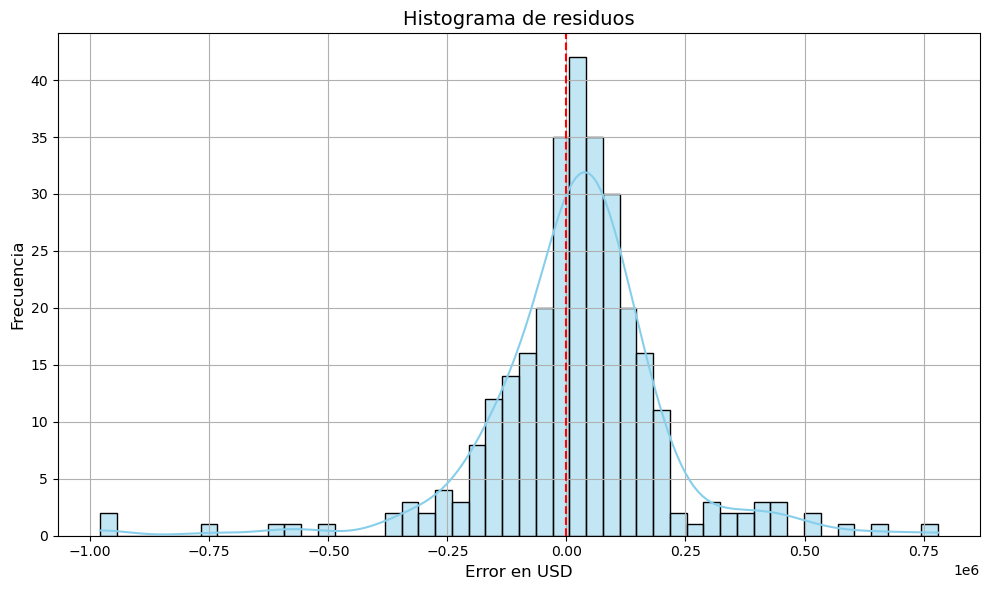

In [146]:
errores = y_pred - y_test # Calcular residuos
plt.figure(figsize=(10, 6))
sns.histplot(errores, bins=50, kde=True, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--') # Línea vertical en 0 para marcar donde no hay error
plt.title("Histograma de residuos", fontsize=14)
plt.xlabel("Error en USD", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

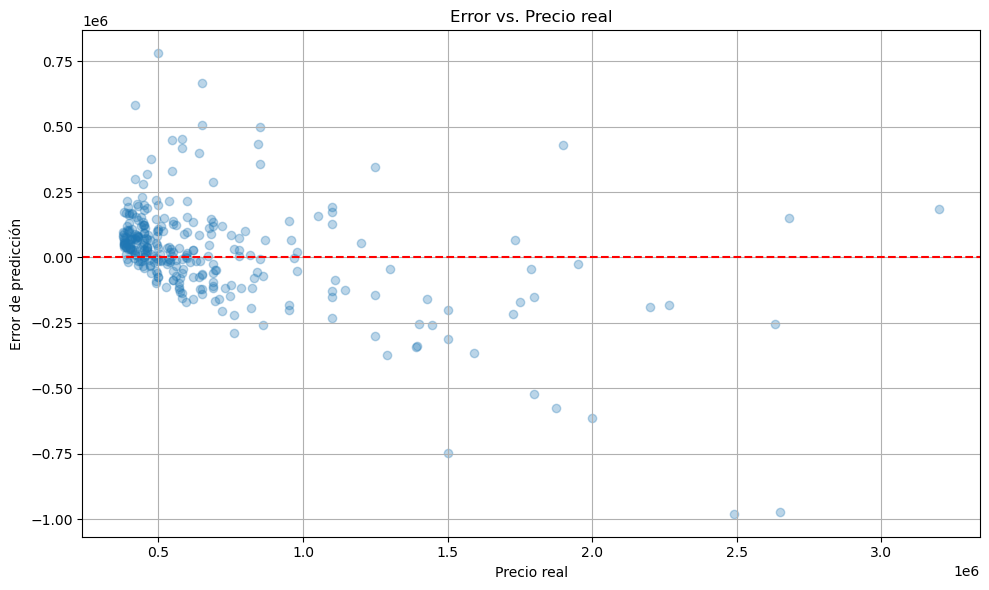

In [147]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, errores, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Precio real')
plt.ylabel('Error de predicción')
plt.title('Error vs. Precio real')
plt.grid(True)
plt.tight_layout()
plt.show()

# Anexo

## Métricas 

- **MAE Mean Absolute Error (Error Absoluto Medio)**		

$$\frac{1}{n} \sum\left\|y_i-\hat{y}_i\right\|$$

MAE tiene la misma unidad que los datos originales, y solo se puede comparar entre modelos cuyos errores se miden en las mismas unidades.

- **RMSE Root Mean Squared Error (Raíz cuadrada de Error cuadrático medio)** 

$$\mathrm{RMSE}=\sqrt{\frac{1}{N} \sum_{i=1}^{N}\left(y_{i}-\hat{y}_{i}\right)^{2}}$$

RMSE solo se puede comparar entre modelos cuyos errores se miden en las mismas unidades. Penaliza errores grandes (útil para evitar predicciones catastróficas).

- **$R^2$ Coeficiente de determinación** 

$$R^2=1-\frac{\sum_{i=1}^N\left(y_i-\hat{y}_i\right)^2}{\sum_{i=1}^N\left(y_i-\bar{y}\right)^2}$$

Representa la proporción de la variabilidad que explica el modelo, sobre la variabilidad total. Entre 0 y 1.

- **MAPE Mean Absolute Percentage Error (Error porcentual absoluto medio)**

$$\mathrm{MAPE}=\frac{1}{n} \sum_{i=1}^n\left|\frac{y_i-\hat{y}_i}{y_i}\right| \times 100$$

Es el error absoluto de cada predicción, dividido por el valor real, expresado como porcentaje, y promediado en todos los casos.

Donde:

${y}$ = Variable target 

$\hat{y}$ = Predicción de  ${y}$ 

$\bar{y}$ = Media de  ${y}$